In [3]:
import pandas as pd
import os
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import AutoModelForSequenceClassification, AutoConfig
from datasets import load_dataset
from datasets import Dataset
import torch
from transformers import Trainer
import evaluate
import numpy as np
from sklearn.metrics import accuracy_score, log_loss, classification_report
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from sklearn.model_selection import train_test_split
from typing import Dict, List, Tuple, Any
import matplotlib.pyplot as plt
import seaborn as sns
import re





In [1]:
import importlib
import finetuning_eval_func
importlib.reload(finetuning_eval_func)
from finetuning_eval_func import create_eval_summary_df, process_csv_social_bias,tokenize_function,custom_collate_fn,evaluation_report,conf_matrix



/Users/mariamielniczuk/anaconda3/envs/capstone_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/Users/mariamielniczuk/anaconda3/envs/capstone_env/bin/python
/Users/mariamielniczuk/anaconda3/envs/capstone_env/bin/python


### Creating a summary of the models performance in the Sweep runs using Cross Entropy

In [4]:
ce_eval_summary = create_eval_summary_df('/Users/mariamielniczuk/Documents/capstone/bias_model_finetuning/hatebert_logs')

Found 10 metric files in /Users/mariamielniczuk/Documents/capstone/bias_model_finetuning/hatebert_logs


In [5]:
ce_eval_summary.sort_values(by='eval_accuracy')

,run_id,eval_loss,eval_accuracy,epoch,step,learning_rate
9,p8ueffpb,1.070177,0.582811,1.0,559.0,NaN
6,2wuafe8z,1.045755,0.631155,1.0,1118.0,NaN
8,qb8zs1s4,1.194129,0.658908,2.0,1118.0,NaN
1,7kxfs0t9,1.731555,0.704566,2.0,2236.0,NaN
7,zbtdpew1,2.816666,0.705461,2.0,1118.0,NaN
5,51acg13c,2.728724,0.714414,2.0,2236.0,NaN
4,ym4rv6rt,3.180809,0.715309,2.0,1118.0,NaN
3,j4hhkmkl,2.346404,0.716204,1.0,1118.0,NaN
0,1cjkn9sp,3.377440,0.717995,2.0,1118.0,NaN
2,t2835ru3,3.295736,0.718890,2.0,2236.0,NaN


### lets Test the best model "t2835ru3" load the checkpoint and make inferences on test_dataset


Let's load and preprocess the dataframes and labelids encoding that will be used for the model comparison later

In [6]:
train_df, val_df, test_df, label2id, id2label = process_csv_social_bias('/Users/mariamielniczuk/Documents/capstone')

Train size: 29790
Validation size: 3724
Test size: 3724


/Users/mariamielniczuk/Documents/capstone/finetuning_eval_func.py:76: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bias_type'].fillna('Neutral', inplace=True)


In [13]:
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")
os.environ["TRANSFORMERS_NO_TF"] = "1"

CUDA available: False
GPU name: No GPU


In [14]:
# def tokenize_function(examples):
#     model_name = "GroNLP/hateBERT"
#     tokenizer = AutoTokenizer.from_pretrained(model_name)
#     return tokenizer(examples["post"], padding="max_length", truncation=True)

train_dataset = Dataset.from_pandas(train_df).map(tokenize_function, batched=True)
val_dataset   = Dataset.from_pandas(val_df).map(tokenize_function, batched=True)
test_dataset  = Dataset.from_pandas(test_df).map(tokenize_function, batched=True)

# Remove extra columns
for dset in [train_dataset, val_dataset, test_dataset]:
    dset = dset.remove_columns([col for col in dset.column_names if col not in ["input_ids", "attention_mask", "label"]])



Map:   0%|          | 0/29790 [00:00<?, ? examples/s]/Users/mariamielniczuk/anaconda3/envs/capstone_env/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Map: 100%|██████████| 3724/3724 [00:00<00:00, 4971.76 examples/s]


In [15]:
# Define a custom collate function for the DataLoader
def custom_collate_fn(batch):
    # Select and collate only the necessary columns
    collated_batch = {}
    collated_batch['input_ids'] = torch.tensor([item['input_ids'] for item in batch], dtype=torch.long)
    collated_batch['attention_mask'] = torch.tensor([item['attention_mask'] for item in batch], dtype=torch.long)
    if 'label' in batch[0]: # Check if label exists in the first item
         collated_batch['labels'] = torch.tensor([item['label'] for item in batch], dtype=torch.long) # Note: model expects 'labels'

    return collated_batch



### Testing the best model from crossentropy loss using the whole test dataset

The following cells can be uncommented if you want to run the inference yourserlf. However you can have access to the inference results by uploading the csv with the results in the uncommented cell

In [18]:

# model_path = "model_t2835ru3/checkpoint-2236"
# model = AutoModelForSequenceClassification.from_pretrained(model_path, local_files_only=True)

In [19]:
# # Create a DataLoader for the test set using the custom collate function
# # Use the tokenized_test_dataset
# test_dataloader = DataLoader(test_dataset, batch_size=8, collate_fn=custom_collate_fn)

# # Set the model to evaluation mode and move to GPU if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
# model.eval()

# predictions = []
# actual_labels = []
# probabilities = []

# # Perform inference
# with torch.no_grad():
#     for batch in test_dataloader:
#         # Move batch to the same device as the model
#         batch = {k: v.to(device) for k, v in batch.items()} # moves all items in the batch

#         outputs = model(**batch)#receiving the batch dictonary k,v
#         logits = outputs.logits
#         probs = torch.softmax(logits, dim=-1)
#         predicted_labels = torch.argmax(logits, dim=-1)
#         #extending the lists
#         predictions.extend(predicted_labels.cpu().numpy())
#         actual_labels.extend(batch['labels'].cpu().numpy()) # Use 'labels' from the batch
#         probabilities.extend(probs.cpu().numpy())



In [20]:
# # Convert predictions and actual_labels to original bias types
# predicted_bias_types = [id2label[pred] for pred in predictions]
# actual_bias_types = [id2label[actual] for actual in actual_labels]



In [21]:
# Create the results DataFrame
# check the length of 'post' matches the length of predictions/actual_labels
# The DataLoader iterates over the dataset, so the number of predictions should match dataset size
# Fetch original posts from test_df based on the order in the DataLoader
# The order in the DataLoader should match the order in the original test_df since we used from_pandas and no shuffling
# results_df = pd.DataFrame({
#     'post': test_df['post'].tolist(), # Get original posts from test_df
#     'actual_bias_type': actual_bias_types,
#     'predicted_bias_type': predicted_bias_types
# })


# # Add probability columns
# prob_df = pd.DataFrame(probabilities, columns=[f'prob_{id2label[i]}' for i in range(len(id2label))])
# results_df = pd.concat([results_df, prob_df], axis=1)



In [ ]:
#results_df.to_csv('/content/drive/MyDrive/capstone_2025/hatebert_logs/results_t2835ru3.csv', index=False)

In [4]:
results_df=pd.read_csv('results_t2835ru3.csv')

In [9]:
results_df.columns

Index(['post', 'actual_bias_type', 'predicted_bias_type', 'prob_Neutral',
       'prob_body', 'prob_culture', 'prob_disabled', 'prob_gender',
       'prob_race', 'prob_social', 'prob_victim'],
      dtype='object')

In [23]:
eval_corss,report_cross=evaluation_report(results_df)


📊 Evaluation Results
----------------------
✅ Overall Accuracy: 72.10%

📋 Classification Report:
              precision    recall  f1-score      support
Neutral        0.855072  0.828863  0.841764  2349.000000
body           0.170213  0.181818  0.175824    44.000000
culture        0.538462  0.651822  0.589744   247.000000
disabled       0.588235  0.533333  0.559441    75.000000
gender         0.535714  0.508475  0.521739   354.000000
race           0.618454  0.639175  0.628644   388.000000
social         0.323944  0.359375  0.340741    64.000000
victim         0.346667  0.384236  0.364486   203.000000
accuracy       0.720999  0.720999  0.720999     0.720999
macro avg      0.497095  0.510887  0.502798  3724.000000
weighted avg   0.728754  0.720999  0.724241  3724.000000


## Testing best model with focal loss function

  Focal Loss: Specifically designed to address extreme class imbalance by down-weighting the loss contributed by well-classified examples (which in our case is the Neutral class). This focuses training more on hard-to-classify examples, which are often from the minority classes.
  

Data Resampling Techniques (Applied to Training Data): Oversampling Minority Classes: increase the number of training samples for the minority classes by randomly duplicating them or using synthetic data generation techniques like SMOTE (Synthetic Minority Over-sampling Technique). SMOTE creates synthetic examples based on existing minority class samples. Undersampling Majority Class: randomly removing samples from the majority class ('Neutral')



In [37]:
import importlib
import finetuning_eval_func
importlib.reload(finetuning_eval_func)
from finetuning_eval_func import create_eval_summary_df, process_csv_social_bias,tokenize_function,custom_collate_fn,evaluation_report,conf_matrix


/Users/mariamielniczuk/anaconda3/envs/capstone_env/bin/python


### Selecting the best model from the focal loss sweep runs

In [40]:
focal_summary_df = create_eval_summary_df('logs_focal')

Found 10 metric files in logs_focal


In [41]:
focal_summary_df

,run_id,eval_loss,eval_accuracy,epoch,step
3,wpwb9oxw,0.876728,0.707252,2.0,2236.0
4,zapg8lmm,0.422696,0.666965,2.0,1118.0
6,midmdhlr,0.423562,0.665175,1.0,1118.0
8,fd415zp6,0.950680,0.660698,1.0,1118.0
2,83v4udtp,0.762440,0.640107,1.0,1118.0
5,k84xbxys,0.507011,0.640107,2.0,1118.0
7,zzzkhebt,0.403139,0.639212,2.0,1118.0
9,q9avuxel,0.516203,0.630260,2.0,1118.0
1,l6g6yt2p,0.421465,0.607878,1.0,559.0
0,2cfhjojw,0.439704,0.600716,1.0,559.0


The following cells can be uncommented if you want to run the inference yourself. Otherwise the uncomented cell will upload the results form the inference for comparisons.

In [ ]:
# model_path = "focal_model_wpwb9oxw"
# model = AutoModelForSequenceClassification.from_pretrained(model_path, local_files_only=True)

In [46]:
# # Create a DataLoader for the focal test set using the custom collate function
# # Use the tokenized_test_dataset
# test_dataloader = DataLoader(test_dataset, batch_size=8, collate_fn=custom_collate_fn)

# # Set the model to evaluation mode and move to GPU if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
# model.eval()

# predictions = []
# actual_labels = []
# probabilities = []

# # Perform inference
# with torch.no_grad():
#     for batch in test_dataloader:
#         # Move batch to the same device as the model
#         batch = {k: v.to(device) for k, v in batch.items()} # moves all items in the batch

#         outputs = model(**batch)#receiving the batch dictonary k,v
#         logits = outputs.logits
#         probs = torch.softmax(logits, dim=-1)
#         predicted_labels = torch.argmax(logits, dim=-1)
#         #extending the lists
#         predictions.extend(predicted_labels.cpu().numpy())
#         actual_labels.extend(batch['labels'].cpu().numpy()) # Use 'labels' from the batch
#         probabilities.extend(probs.cpu().numpy())

In [47]:
# # Convert predictions and actual_labels to original bias types
# predicted_bias_types_focal = [id2label[pred] for pred in predictions]
# actual_bias_types_focal = [id2label[actual] for actual in actual_labels]


In [48]:
# Create the results DataFrame
# check the length of 'post' matches the length of predictions/actual_labels
# The DataLoader iterates over the dataset, so the number of predictions should match dataset size
# Fetch original posts from test_df based on the order in the DataLoader
# The order in the DataLoader should match the order in the original test_df since we used from_pandas and no shuffling
# results_focal_df = pd.DataFrame({
#     'post': test_df['post'].tolist(), # Get original posts from test_df
#     'actual_bias_type': actual_bias_types_focal,
#     'predicted_bias_type': predicted_bias_types_focal
# })


# # Add probability columns
# prob_foc_df = pd.DataFrame(probabilities, columns=[f'prob_{id2label[i]}' for i in range(len(id2label))])
# results_focal_df = pd.concat([results_focal_df, prob_foc_df], axis=1)


In [ ]:
#results_focal_df.to_csv('results_focal_wpwb9oxw.csv', index=False)

In [6]:
results_focal_df=pd.read_csv('results_focal_wpwb9oxw.csv')

In [8]:
results_focal_df.head()

,post,actual_bias_type,predicted_bias_type,prob_Neutral,prob_body,prob_culture,prob_disabled,prob_gender,prob_race,prob_social,prob_victim
0,"""When people say """"it doesn't seem like you &a...",Neutral,Neutral,0.889023,0.014832,0.007010,0.012313,0.027898,0.015606,0.022597,0.010721
1,"""What are we to say of a nation which lives un...",Neutral,Neutral,0.671241,0.025302,0.061262,0.017214,0.024884,0.059398,0.069558,0.071140
2,On moms this nigga fucked up bringing my famil...,race,race,0.095072,0.017206,0.034143,0.002654,0.090739,0.719647,0.019182,0.021357
3,"like, thanks for that. i never would have know...",Neutral,Neutral,0.855899,0.018921,0.018863,0.014237,0.016760,0.026384,0.018001,0.030936
4,I can see a little waves of water crashing ove...,Neutral,Neutral,0.705782,0.041553,0.020746,0.016855,0.045868,0.045132,0.016316,0.107747


In [ ]:
# results_focal_df[results_focal_df['predicted_bias_type'] == 'culture']

In [50]:
eval_focal,report_focal=evaluation_report(results_focal_df)


📊 Evaluation Results
----------------------
✅ Overall Accuracy: 66.49%

📋 Classification Report:
              precision    recall  f1-score      support
Neutral        0.925301  0.653895  0.766276  2349.000000
body           0.250000  0.113636  0.156250    44.000000
culture        0.563636  0.753036  0.644714   247.000000
disabled       0.505155  0.653333  0.569767    75.000000
gender         0.395173  0.740113  0.515241   354.000000
race           0.579048  0.783505  0.665936   388.000000
social         0.280374  0.468750  0.350877    64.000000
victim         0.322981  0.512315  0.396190   203.000000
accuracy       0.664876  0.664876  0.664876     0.664876
macro avg      0.477709  0.584823  0.508157  3724.000000
weighted avg   0.754487  0.664876  0.685418  3724.000000


In [51]:
conf_matrix(results_focal_df, id2label,id2label)
# plt.show()

,Neutral,body,culture,disabled,gender,race,social,victim
Neutral,1536,10,63,37,337,153,55,158
body,8,5,0,2,13,0,0,16
culture,16,0,186,2,0,28,4,11
disabled,11,1,0,49,5,1,0,8
gender,27,1,7,1,262,21,16,19
race,24,1,29,4,21,304,2,3
social,11,0,5,1,6,8,30,3
victim,27,2,40,1,19,10,0,104


### Compare the two models

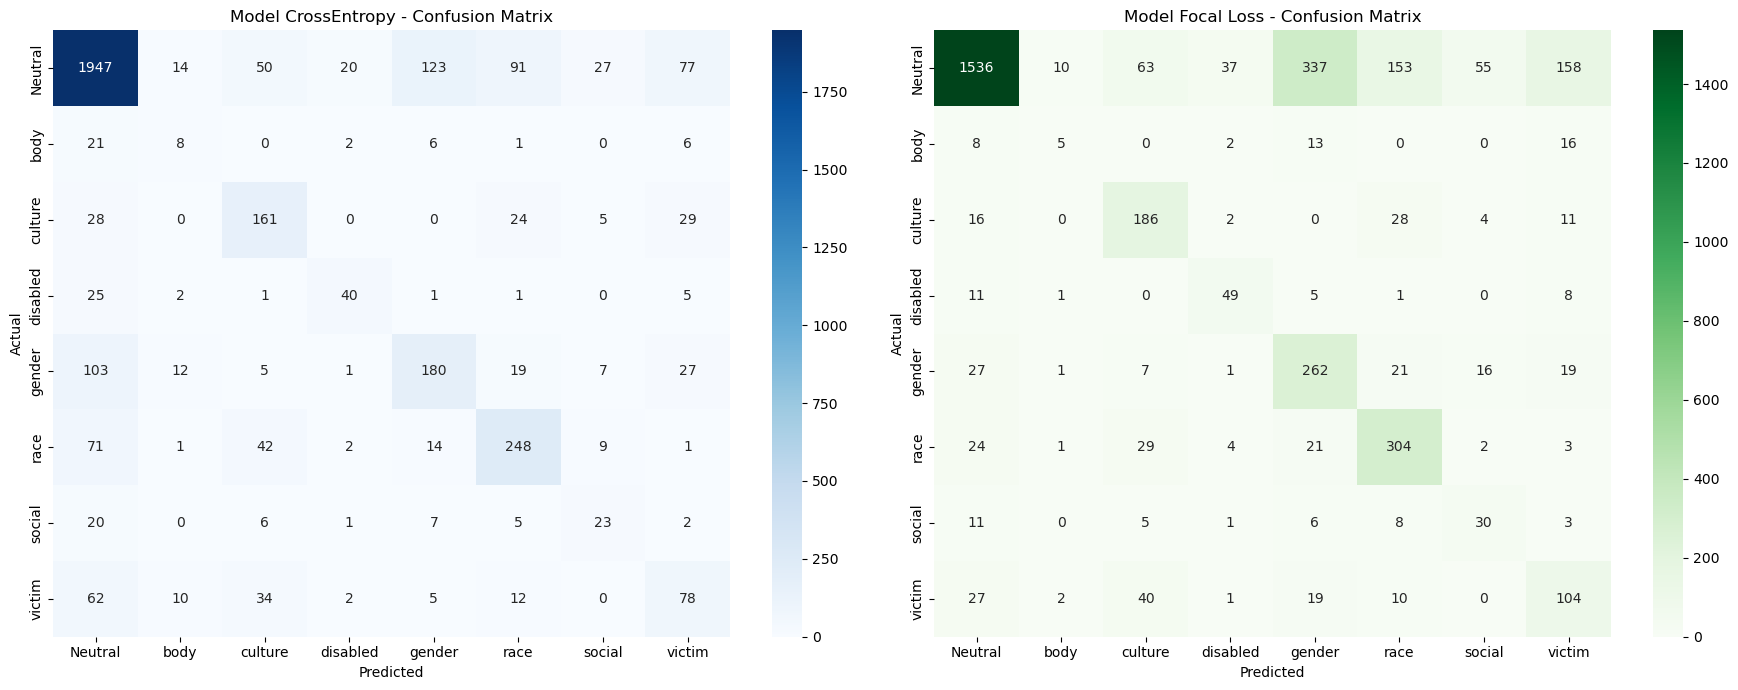

In [52]:
# both confusion matrices without plotting
cm_df_a = conf_matrix(results_df, id2label, label2id)
cm_df_b = conf_matrix(results_focal_df, id2label, label2id)

# Plot them side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

sns.heatmap(cm_df_a, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Model CrossEntropy - Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(cm_df_b, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title("Model Focal Loss - Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

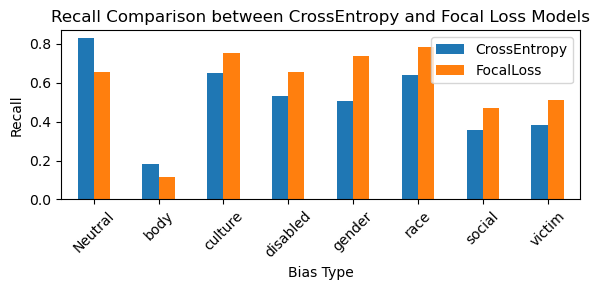

In [53]:
common_labels = report_cross.index.intersection(report_focal.index)

recall_comparison = pd.DataFrame({
    'CrossEntropy': report_cross.loc[common_labels, 'recall'],
    'FocalLoss': report_focal.loc[common_labels, 'recall'],
}, index=common_labels)

recall_comparison = recall_comparison[~recall_comparison.index.str.contains("avg|accuracy")]
recall_comparison.plot(kind='bar', figsize=(6, 3))
plt.title("Recall Comparison between CrossEntropy and Focal Loss Models")
plt.ylabel("Recall")
plt.xlabel("Bias Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()  

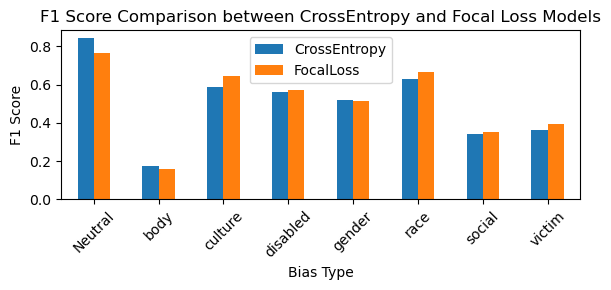

In [54]:
f1_comparison = pd.DataFrame({
    'CrossEntropy': report_cross.loc[common_labels, 'f1-score'],
    'FocalLoss': report_focal.loc[common_labels, 'f1-score'],
}, index=common_labels)

f1_comparison = f1_comparison[~f1_comparison.index.str.contains("avg|accuracy")]
f1_comparison.plot(kind='bar', figsize=(6, 3))
plt.title("F1 Score Comparison between CrossEntropy and Focal Loss Models")
plt.ylabel("F1 Score")
plt.xlabel("Bias Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
#testing the significance of the improvement in Focal Loss results

In [13]:
# Rename columns to avoid collision when merging
df_ce = results_df.rename(columns={
    'predicted_bias_type': 'pred_ce',
    'actual_bias_type': 'actual'
})[['post', 'actual', 'pred_ce']]

df_focal = results_focal_df.rename(columns={
    'predicted_bias_type': 'pred_focal',
    'actual_bias_type': 'actual_focal'
})[['post', 'pred_focal', 'actual_focal']]

# Check that actual labels match in both dataframes
if not (df_ce['actual'].equals(df_focal['actual_focal'])):
    raise ValueError("Mismatch between actual labels in the two result DataFrames.")

# Remove duplicate actual column
df_focal = df_focal.drop(columns=['actual_focal'])

# Merge by post to align predictions from both models
df_all = df_ce.merge(df_focal, on='post')



In [14]:
df_all.head()

,post,actual,pred_ce,pred_focal
0,"""When people say """"it doesn't seem like you &a...",Neutral,Neutral,Neutral
1,"""What are we to say of a nation which lives un...",Neutral,Neutral,Neutral
2,On moms this nigga fucked up bringing my famil...,race,Neutral,race
3,"like, thanks for that. i never would have know...",Neutral,Neutral,Neutral
4,I can see a little waves of water crashing ove...,Neutral,Neutral,Neutral


In [ ]:
from scipy.stats import binomtest
# our H0 is that focal and CE are the same
# Our Ha is that focal is better than CE
# binomial test calculates the probability of getting at least the observed number of
# Focal wins n01 out of n trials, given p=0.5 (focal = CE)

# Boolean masks for correct/incorrect predictions
ce_correct = df_all['pred_ce'] == df_all['actual']
focal_correct = df_all['pred_focal'] == df_all['actual']

# Off-diagonal counts
n01 = ((~ce_correct) & (focal_correct)).sum()  # CE wrong, Focal correct
n10 = ((ce_correct) & (~focal_correct)).sum()  # CE correct, Focal wrong

successes = int(n01)
trials = int(n01 + n10)

if trials == 0:
    print("No discordant pairs: models agree on all predictions.")
else:
    res = binomtest(successes, trials, p=0.5, alternative='greater')
    p_one_sided = res.pvalue  # ✅ Extract p-value here

    print(f"n01 (Focal correct, CE wrong): {n01}")
    print(f"n10 (CE correct, Focal wrong): {n10}")
    print(f"One-sided p-value (H1: Focal > CE): {p_one_sided:.6f}")

    if p_one_sided < 0.05:
        print("Statistically significant evidence that Focal is better.")
    else:
        print("No statistically significant evidence that Focal is better.")

n01 (Focal correct, CE wrong): 327
n10 (CE correct, Focal wrong): 530
One-sided p-value (H1: Focal > CE): 1.000000
No statistically significant evidence that Focal is better.


Eventhough focal loss improved recall in minority classes, the margin is very slim and the majority class has been more negatively impacted.
The same happened with the F1 evaluation, where focal loss increased the recall in minority classes but diminished the precision in the Neutral class.


Our decision is to use the best corss entropy model, that has a better accuracy in the majority class, because we are going to provide also the probablility of the content containing also other classes. We are not deciding for the Focal Loss because even it has better recall and F1 for minority classes its performance in those classes is still weak, and it has diminished the results for the majority class too.